## Imports and configuration

In [13]:
import os, requests
import numpy as np
import pandas as pd
import wikipedia as wp
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import stats

# We do only read operations, therefore no user config is necessary.
# Normally the system crashes when there is no user config unless we tell it otherwise with this environment variable.
#   0 is default
#   1 means ignore the config
#   2 means ignore the config and don't throw warnings
os.environ["PYWIKIBOT_NO_USER_CONFIG"] = "2"

# Now we can import pywikibot
import pywikibot as pwb
import pywikibot.data.api as api

# Then we can setup references for Wikipedia and Wikidata
wiki_site = pwb.Site(code="en", fam="wikipedia")
data_site = pwb.Site(code="wikidata", fam="wikidata")
repo = data_site.data_repository()

# Setting important dates
stime = "2015070100"
etime = str(datetime.today().date()).replace("-", "") + "00"

# We list here the search terms for EPFL
epfl_alts = [
    "EPFL",
    "École Polytechnique Fédérale de Lausanne",
    "Swiss Federal Institute of Technology",
    "EPF Lausanne",
    "ETH Lausanne",
    "Poly Lausanne",
]

## Limitations of the search functionality
Search on `Pywikibot` works fine but seems to cap at 10'000 items, whereas searching on Wikipedia goes clearly above, as the example below shows. This is still much better than the Python `wikipedia` package which caps at 500. For reference, searching for "obama" on Wikipedia yields over 32'000 results. But for the context of our task, this is acceptable as EPFL is mentioned in less than 1'000 articles overall and is unlikely to increase tenfold overnight.

In [2]:
obama_query_1 = wp.search("obama", results=999999)
obama_count_1 = len(obama_query_1)

print("Using the Wikipedia package, searching for 'obama' yields a maximum of", obama_count_1, "results.")

Using the Wikipedia package, searching for 'obama' yields a maximum of 500 results.


In [3]:
obama_query_2 = wiki_site.search("obama", namespaces=0)
obama_count_2 = len([x for _, x in zip(range(999999), obama_query_2)])

print("Using Pywikibot, searching for 'obama' yields a maximum of", obama_count_2, "results.")

Using Pywikibot, searching for 'obama' yields a maximum of 10000 results.


In [4]:
for alt in epfl_alts:
    epfl_query = wiki_site.search(alt, namespaces=0)
    epfl_count = len([x for _, x in zip(range(999999), epfl_query)])

    print("Searching for '" + alt + "' yields", epfl_count, "results.")
    
print("All of those results are within the range of Pywikibot. Success!")

Searching for 'EPFL' yields 744 results.
Searching for 'École Polytechnique Fédérale de Lausanne' yields 652 results.
Searching for 'Swiss Federal Institute of Technology' yields 4004 results.
Searching for 'EPF Lausanne' yields 184 results.
Searching for 'ETH Lausanne' yields 375 results.
Searching for 'Poly Lausanne' yields 69 results.
All of those results are within the range of Pywikibot. Success!


In [5]:
for alt in ["ecublens", "écublens", "Ecublens", "Écublens"]:
    test_query = wiki_site.search(alt, namespaces=0)
    test_count = len([x for _, x in zip(range(999999), test_query)])

    print("Searching for '" + alt + "' yields", test_count, "results.")
    
print("This certifies that Wikipedia's search API is case- and accentuation-insensitive.")

Searching for 'ecublens' yields 58 results.
Searching for 'écublens' yields 58 results.
Searching for 'Ecublens' yields 58 results.
Searching for 'Écublens' yields 58 results.
This certifies that Wikipedia's search API is case- and accentuation-insensitive.


With that out of the way, let's generate a list of all the pages that mention EPFL. We set `namespace=0` as this namespace is the one that contains regular pages. Note that searches from Pywikibot are ordered alphabetically by default, unlike what the Wikipedia API does.

In [6]:
epfl_searches = [wiki_site.search(alt.lower(), where="text", namespaces=0) for alt in epfl_alts]
epfl_pages_raw = [list(s) for s in epfl_searches]
epfl_pages = list(set([item for sublist in epfl_pages_raw for item in sublist]))

It is important to note that Wikipedia started storing page view statistics since July 1st, 2015. This means we will not have any data available before that time.

## Accessing a page

Let's look at the different ways we can refer to a given page. We will be using Martin Vetterli's page for our examples.

In [7]:
# We can get a page by name
page = pwb.Page(wiki_site, u"Martin Vetterli")
page

Page('Martin Vetterli')

In [8]:
# We can get its data reference
item = page.data_item()
item

ItemPage('Q6776811')

In [9]:
# We can get the reference directly
item = pwb.ItemPage(repo, "Q6776811")
item

ItemPage('Q6776811')

In [10]:
# And we can get all the pages linked to this reference through WikiData
for k, v in dict(item.sitelinks).items():
    print(k + "\n\t" + v.ns_title())

commonswiki
	Category:Martin Vetterli
dewiki
	Martin Vetterli
enwiki
	Martin Vetterli
frwiki
	Martin Vetterli
frwikiquote
	Martin Vetterli


## Mentions of EPFL in a page

In [15]:
def pagecounts(page, strings):
    return [page.text.count(s) for s in strings]

In [16]:
pcs = pagecounts(page, epfl_alts)
pcs

[12, 6, 0, 0, 0, 0]

In [17]:
req = api.Request(site=data_site, parameters={'action': 'query',
                                                'titles': item,
                                                'prop': 'pageviews',
                                                'pvipdays': 1000})

print("As the warning above says, the default API request gives us a maximum of", len(req.submit()['query']['pages'][str(item.pageid)]['pageviews']), "days of data. This is insufficient.")

As the warning above says, the default API request gives us a maximum of 60 days of data. This is insufficient.


In [18]:
# Set dates
pp_first = datetime.strptime(stime, "%Y%m%d00").strftime("%B %d, %Y").replace(" 0", " ")
pp_today = datetime.today().strftime("%B %d, %Y").replace(" 0", " ")

# Request data
page_name = "Martin_Vetterli"
pv_url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/%s/daily/%s/%s"
r = requests.get(pv_url % (page_name, stime, etime))
print("Digging deeper into the API, we see we have access to", len(r.json()['items']), "days of pageview data since", pp_first, "as of", pp_today + ".")

Digging deeper into the API, we see we have access to 1966 days of pageview data since July 1, 2015 as of November 17, 2020.


## Mentions over time

For `getPageChanges`, we recover all revisions at once at it is significantly faster to do that than to call `page.getOldVersion` continuously.

It is important to note that our process is simplified to improve performance by minimizing the number of revisions requested; if a page had 5 mentions in 2008, 5 in 2010, but 4 in 2009, the 4 will be glossed over as we assume the amount of such cases will be rare and insignificant.

Getting the revisions without the content is approximately 7 times faster on large pages (35 vs. 5 seconds), while getting the text from the revisions or from `getOldVersion` takes the same amount of time. However we are still getting faster results for revisions with content when it is part of our functions.

In [19]:
def getCounts(revs, strings, idx):
    page = revs[idx]
    return sum([page.text.count(s) for s in strings])

def getOrUpdate(revs, strings, counts, idx, changes):
    if idx not in counts:
        temp = getCounts(revs, strings, idx)
        counts[idx] = temp
        
        # Do not consider the count if an earlier revision had more
        if not any([counts[k] > temp for k in counts.keys() if k < idx]):
            changes[temp] = min(changes.get(temp) or idx, idx) 
    
    return counts[idx]

def getMentions(page, strings):
    if not getCounts([page], strings, 0):
        return None
    
    cnt = page.revision_count()
    revs = list(page.revisions(reverse=True, content=True))

    # Start with whole scope
    queue = [(0, cnt - 1)]
    
    # To avoid double checking revisions we store the counts here
    cnts = {}
    
    # And here we store the count-index pairs
    changes = {}

    while queue:
        # Process first element
        r0, r1 = queue[0]
        queue = queue[1:]

        # Only proceed if current scope covers multiple indices
        if r0 != r1:
            # Get counts for both indices
            v0 = getOrUpdate(revs, strings, cnts, r0, changes)
            v1 = getOrUpdate(revs, strings, cnts, r1, changes)

            # Only proceed if there is a change of count in the current scope
            if v0 != v1 and abs(r1 - r0) > 1:
                mid = (r0 + r1) // 2
                queue.extend([(r0, mid), (mid, r1)])

    changes = {revs[v]["timestamp"]: k for k, v in changes.items()}
    changes = {datetime.combine(k.date(), k.time()): v for k, v in changes.items()}
    
    # Here we simplify our data to a maximum of one point per day (we take the last one)
    changes = pd.Series(changes, name="Mentions").sort_index().groupby(pd.Grouper(freq="1D")).nth(-1)
    return changes

In [20]:
pms = getMentions(page, epfl_alts)
pms

2007-08-08     5
2013-10-23     6
2014-02-13    11
2016-02-26    12
2017-01-01    15
2017-04-02    18
Name: Mentions, dtype: int64

<AxesSubplot:>

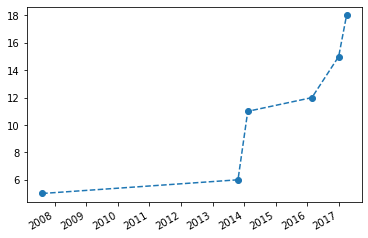

In [21]:
pms.plot(linestyle='--', marker='o')

## Views of a page over time

Here we compute the pageviews for each day and highlight the outliers.

In [22]:
def pageviews(page, stime, etime):
    req = requests.get(pv_url % (page.title(), stime, etime))
    serie = pd.Series({datetime.strptime(str(item['timestamp'])[:-2], "%Y%m%d"): item['views'] for item in req.json()['items']}, name="Views")
    return serie

def outliers(serie):
    return pd.Series(serie[np.abs(stats.zscore(serie)) > 3], name="Outliers")

In [23]:
pvs = pageviews(page, stime, etime)
pvs

2015-07-01    11
2015-07-02    13
2015-07-03     5
2015-07-04     4
2015-07-05     8
              ..
2020-11-12    23
2020-11-13    21
2020-11-14    14
2020-11-15    18
2020-11-16    21
Name: Views, Length: 1966, dtype: int64

In [24]:
ols = outliers(pvs)
ols

2016-02-24    1233
2016-02-25     362
2016-02-26     135
2019-12-05     233
2019-12-06     469
2020-02-12     126
Name: Outliers, dtype: int64

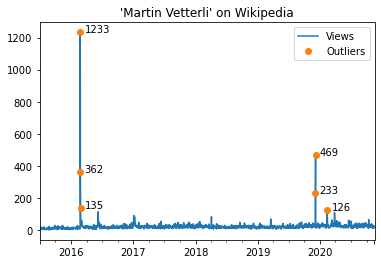

In [25]:
ax = pvs.plot(legend=True, title="'Martin Vetterli' on Wikipedia")
ax = ols.plot(legend=True, ax=ax, linestyle="", marker="o")
for i, each in enumerate(ols.index):
    y = ols[each]
    ax.text(each + timedelta(25), y, y)

This last graph shows us that histograms are irrelevant here as in most cases page viewing numbers are very consistent for most subjects.

## Backlinks

So far I haven't found an efficient way to account for backlinks in page revisions. Therefore this will be skipped for now.

## Edits

In [26]:
def getPageSize(page):
    revs = list(page.revisions(reverse=True))
    df = pd.DataFrame([dict(r) for r in revs])
    df = df[["userid", "timestamp", "size", "minor"]]
    df = df.set_index("timestamp")
    df["diff"] = (df['size'] - df['size'].shift(1)).abs()
    df["diff"] = df["diff"].fillna(df["size"])
    df = df["size"].groupby(pd.Grouper(freq="1D")).nth(-1)
    
    return df.rename("Size")

In [27]:
psz = getPageSize(page)
psz

timestamp
2007-08-08     1441
2007-09-15     1439
2008-08-21     1682
2008-09-12     1682
2008-11-01     1683
              ...  
2020-07-02    11839
2020-08-14    11897
2020-08-22    11896
2020-09-25    11895
2020-11-02    11843
Name: Size, Length: 63, dtype: int64

<AxesSubplot:xlabel='timestamp'>

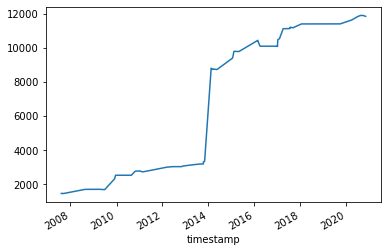

In [28]:
psz.plot()

In [29]:
def getPageScore(page):
    # Get mentions
    pms = getMentions(page, epfl_alts)
    
    if pms is None:
        return None
    
    # Get page views
    pvs = pageviews(page, stime, etime)
    
    # Get page size
    psz = getPageSize(page)
    
    # Combine the data
    df = pd.concat([pvs, psz.reindex(pvs.index), pms.reindex(pvs.index)], axis=1)
    df = df.ffill(axis=0)
    df["Size"] = df["Size"].fillna(psz[psz.index.difference(pvs.index)[-1]])
    df["Mentions"] = df["Mentions"].fillna(pms[pms.index.difference(pvs.index)[-1]])
    
    # Generate score
    df["Score"] = df["Mentions"] * df["Views"] / df["Size"]
    
    return df

In [30]:
psc = getPageScore(page)
psc

,Views,Size,Mentions,Score
2015-07-01,11,9894.0,11.0,0.012230
2015-07-02,13,9894.0,11.0,0.014453
2015-07-03,5,9894.0,11.0,0.005559
2015-07-04,4,9894.0,11.0,0.004447
2015-07-05,8,9894.0,11.0,0.008894
...,...,...,...,...
2020-11-12,23,11843.0,18.0,0.034957
2020-11-13,21,11843.0,18.0,0.031918
2020-11-14,14,11843.0,18.0,0.021278
2020-11-15,18,11843.0,18.0,0.027358


<AxesSubplot:>

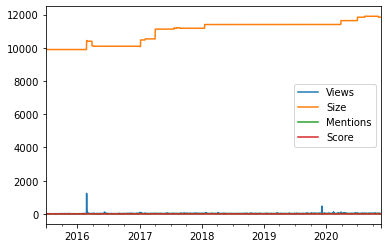

In [31]:
psc.plot()

## Combining Data

In [32]:
cl = pd.DataFrame(columns=["views", "mentions", "edits"])
cl.loc[495998] = [1, 2, 4]
cl

,views,mentions,edits
495998,1,2,4


In [33]:
for i, p in enumerate(epfl_pages[:10]):
    print(i)
    getPageScore(p)

0
1
2
3
4
5
6
7
8
9


## Editors

In [34]:
for uid, dat in df.groupby("userid"):
    print(uid)
    for val, x in dat.groupby("minor"):
        print(val, sum(x["diff"]))

NameError: name 'df' is not defined

entry over time
* list of incoming links
* list of outgoing links
* mention history

work with user pages  
potentially use the wikipedia package for smaller operations as it seems to be faster, maybe do some timed tests

count improve counts by checking revisions 5 before and 5 after to ignore edit wars and such

Will need to handle the problem or redirects and page name changes in the future.

Will need to classify whether we found the subject through keywords or if EPFL was mentioned.

We assume mentions are only added for performance and simplicity reasons. It's very rare that content will be removed from pages.

Link pages with contributors

value of page = # of mentions * # of pageviews / size of page